In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from util import Util
from qos_data_manager import QosDataManager
from matplotlib.backends.backend_pdf import PdfPages
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import metrics as m
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.backends.backend_pdf import PdfPages
#from keras.utils.vis_utils import plot_model


# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 
mode = 'qos'
excel_file_video = r"video_dataset_with_costs(qos).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(qos).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "mrs"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video

used_features = [#'Users',
                 'Avg RAM used (MB)',
                 #'Avg RAM (unused, KiB)',
                 #'Disk read bytes', 
                 'Disk write bytes rate',
                 'End-to-end', 
                 #'No. SLO violations, threshold 5s (%)',
                 'Avg. CPU utilization (%)',
                 #'Max CPU utilization (%)', 
                 #'Min RAM',
                 #'Min free RAM (KiB)', 
                 #'NW Ingress (GB)',
                 'NW Egress (GB)']
outcome_label = 'End-to-end'
############################################################

dataManager = QosDataManager(excel_file, outcome_label, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()        

def transformX(X):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)       
    return X

def transformY(Y):
    data = Y.copy().values
    data = np.sqrt(data)
    ret = pd.Series(data)
    return ret

def invTrans(X):
    return X*X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print(len(working_metrics))

util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


Using TensorFlow backend.


3 features removed (std +/- 3) -  large
24 features removed (std +/- 3) -  xlarge
31 features removed (std +/- 3) -  all
717


# Neural net

In [2]:
import keras 
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


def baseline_model():
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'tanh', kernel_initializer='glorot_normal', input_dim = X.shape[1]))
    
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    #model.add(Dense(units = 64, activation = 'relu', kernel_initializer='normal'))
    
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))

    model.add(Dense(units = 1))
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.compile(optimizer = adam, loss = 'mse')
    return model

Epoch 1/500
501/501 [==============================] - 0s 579us/step - loss: 4043.7192
Epoch 2/500
501/501 [==============================] - 0s 50us/step - loss: 1303.6698
Epoch 3/500
501/501 [==============================] - 0s 42us/step - loss: 755.7578
Epoch 4/500
501/501 [==============================] - 0s 48us/step - loss: 576.7989
Epoch 5/500
501/501 [==============================] - 0s 38us/step - loss: 489.2326
Epoch 6/500
501/501 [==============================] - 0s 98us/step - loss: 431.2352
Epoch 7/500
501/501 [==============================] - 0s 70us/step - loss: 384.9054
Epoch 8/500
501/501 [==============================] - 0s 78us/step - loss: 354.5465
Epoch 9/500
501/501 [==============================] - 0s 70us/step - loss: 366.2114
Epoch 10/500
501/501 [==============================] - 0s 66us/step - loss: 292.4425
Epoch 11/500
501/501 [==============================] - 0s 76us/step - loss: 256.1626
Epoch 12/500
501/501 [==============================] - 0s 9

501/501 [==============================] - 0s 52us/step - loss: 12.5119
Epoch 97/500
501/501 [==============================] - 0s 60us/step - loss: 10.5362
Epoch 98/500
501/501 [==============================] - 0s 80us/step - loss: 9.8953
Epoch 99/500
501/501 [==============================] - 0s 48us/step - loss: 9.5360
Epoch 100/500
501/501 [==============================] - 0s 58us/step - loss: 15.7172
Epoch 101/500
501/501 [==============================] - 0s 52us/step - loss: 11.2254
Epoch 102/500
501/501 [==============================] - 0s 46us/step - loss: 10.6369
Epoch 103/500
501/501 [==============================] - 0s 66us/step - loss: 16.5090
Epoch 104/500
501/501 [==============================] - 0s 64us/step - loss: 14.2387
Epoch 105/500
501/501 [==============================] - 0s 42us/step - loss: 11.9164
Epoch 106/500
501/501 [==============================] - 0s 42us/step - loss: 12.7621
Epoch 107/500
501/501 [==============================] - 0s 44us/step - l

501/501 [==============================] - 0s 50us/step - loss: 6.5047
Epoch 193/500
501/501 [==============================] - 0s 62us/step - loss: 6.0649
Epoch 194/500
501/501 [==============================] - 0s 60us/step - loss: 6.7079
Epoch 195/500
501/501 [==============================] - 0s 82us/step - loss: 8.5618
Epoch 196/500
501/501 [==============================] - 0s 64us/step - loss: 6.7786
Epoch 197/500
501/501 [==============================] - 0s 62us/step - loss: 6.1861
Epoch 198/500
501/501 [==============================] - 0s 60us/step - loss: 10.8519
Epoch 199/500
501/501 [==============================] - 0s 84us/step - loss: 8.4253
Epoch 200/500
501/501 [==============================] - 0s 58us/step - loss: 15.9690
Epoch 201/500
501/501 [==============================] - 0s 58us/step - loss: 9.5787
Epoch 202/500
501/501 [==============================] - 0s 52us/step - loss: 8.3433
Epoch 203/500
501/501 [==============================] - 0s 48us/step - loss:

501/501 [==============================] - 0s 68us/step - loss: 4.9380
Epoch 289/500
501/501 [==============================] - 0s 44us/step - loss: 5.3877
Epoch 290/500
501/501 [==============================] - 0s 44us/step - loss: 4.6507
Epoch 291/500
501/501 [==============================] - 0s 58us/step - loss: 6.2227
Epoch 292/500
501/501 [==============================] - 0s 56us/step - loss: 5.4119
Epoch 293/500
501/501 [==============================] - 0s 48us/step - loss: 5.2247
Epoch 294/500
501/501 [==============================] - 0s 62us/step - loss: 5.9586
Epoch 295/500
501/501 [==============================] - 0s 46us/step - loss: 5.8335
Epoch 296/500
501/501 [==============================] - 0s 52us/step - loss: 5.7600
Epoch 297/500
501/501 [==============================] - 0s 58us/step - loss: 6.3229
Epoch 298/500
501/501 [==============================] - 0s 48us/step - loss: 5.2740
Epoch 299/500
501/501 [==============================] - 0s 48us/step - loss: 4

501/501 [==============================] - 0s 28us/step - loss: 4.3051
Epoch 385/500
501/501 [==============================] - 0s 22us/step - loss: 13.2895
Epoch 386/500
501/501 [==============================] - 0s 26us/step - loss: 13.2046
Epoch 387/500
501/501 [==============================] - 0s 26us/step - loss: 19.8772
Epoch 388/500
501/501 [==============================] - 0s 30us/step - loss: 15.4890
Epoch 389/500
501/501 [==============================] - 0s 34us/step - loss: 9.4453
Epoch 390/500
501/501 [==============================] - ETA: 0s - loss: 6.013 - 0s 34us/step - loss: 7.2226
Epoch 391/500
501/501 [==============================] - 0s 24us/step - loss: 5.4691
Epoch 392/500
501/501 [==============================] - 0s 28us/step - loss: 5.0204
Epoch 393/500
501/501 [==============================] - 0s 24us/step - loss: 4.5485
Epoch 394/500
501/501 [==============================] - 0s 26us/step - loss: 5.2492
Epoch 395/500
501/501 [============================

501/501 [==============================] - 0s 24us/step - loss: 6.5510
Epoch 481/500
501/501 [==============================] - 0s 26us/step - loss: 6.2450
Epoch 482/500
501/501 [==============================] - 0s 26us/step - loss: 4.8858
Epoch 483/500
501/501 [==============================] - 0s 26us/step - loss: 8.0099
Epoch 484/500
501/501 [==============================] - 0s 24us/step - loss: 4.7794
Epoch 485/500
501/501 [==============================] - 0s 24us/step - loss: 6.9384
Epoch 486/500
501/501 [==============================] - 0s 28us/step - loss: 14.3129
Epoch 487/500
501/501 [==============================] - 0s 24us/step - loss: 8.5351
Epoch 488/500
501/501 [==============================] - 0s 24us/step - loss: 6.0986
Epoch 489/500
501/501 [==============================] - 0s 24us/step - loss: 4.4539
Epoch 490/500
501/501 [==============================] - 0s 24us/step - loss: 4.4225
Epoch 491/500
501/501 [==============================] - 0s 24us/step - loss: 

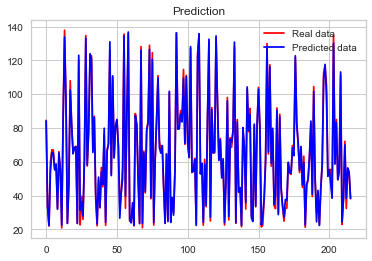

In [3]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


# Splitting the dataset into the Training set and Test set
X,Y = dataManager.getXY_panda(working_metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

#Zakomentirano za Permutation Importance 
model = baseline_model()
# Fitting the ANN to the Training set
history = model.fit(X_train, Y_train, batch_size = 50, epochs = 500)

Y_pred = model.predict(X_test)
Y_pred = np.concatenate( Y_pred, axis=0 )

plt.plot(Y_test.values, color = 'red', label = 'Real data')
plt.plot(Y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#Plot the neural network, missing pydot package
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#plot_model(model, show_shapes=True, show_layer_names=True)

model_info = {}
model_info['model'] = model
model_info['X_train'] = X_train
model_info['X_test'] = X_test
model_info['Y_train'] = Y_train
model_info['Y_test'] = Y_test
model_info['predicted'] = model.predict(X_test)[:,0]


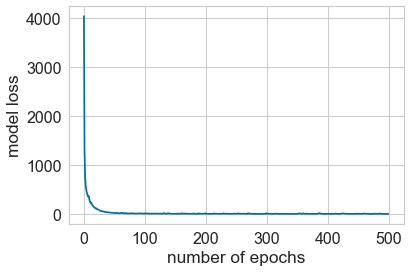

MAE: 219.92720040949123
MSE: 110073.90350669342
MAPE: 6.955454166314777
RMSE: 331.7738740568543
EVS: 0.9955102943989881
AIC: -25.968371353858707
AICc: -25.778797894143068
BIC: 2529.025083787697
R2: 0.9953879043155098
R2(adj): 0.995300471221965


In [4]:
# summarize history for loss
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_NN_model_loss.pdf') as pdf:
    f, ax = plt.subplots()
    plt.plot(history.history['loss'])
    #plt.title('model loss')
    plt.ylabel('model loss', fontsize = 'xx-large')
    plt.xlabel('number of epochs', fontsize = 'xx-large')
    #plt.legend(fontsize = 'xx-large')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    pdf.savefig(f, bbox_inches='tight')

util.regression_report(Y_test, Y_pred, "NN", X.shape[1])

# Analysis

## Residuals 

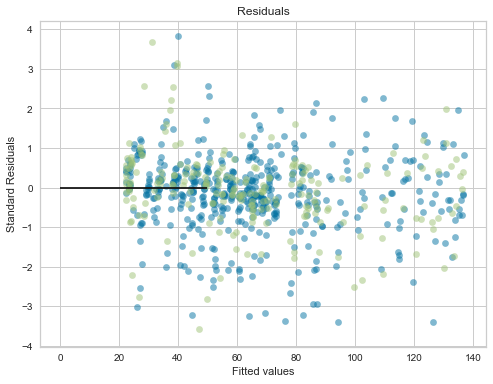

In [5]:
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(model.predict(X_train)[:,0], util.get_standard_residuals(model.predict(X_train)[:,0],Y_train), c='b', s=40, alpha=0.5)
plt.scatter(model.predict(X_test)[:,0], util.get_standard_residuals(model.predict(X_test)[:,0],Y_test), c='g', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(str(model))
plt.ylabel('Standard Residuals')
plt.xlabel('Fitted values')	   
plt.title("Residuals")
plt.show()

## Predicted vs Original

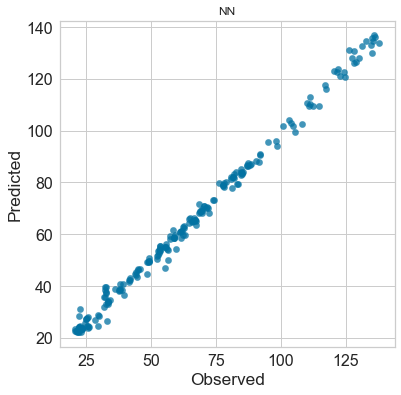

In [6]:
#f, ax = plt.subplots(figsize=(8, 6))
#util.pred_true_graph(model_info, "NN")

with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_NN_predicted_vs_original.pdf') as pdf:
    f, ax = plt.subplots(figsize=(6, 6))
    util.pred_true_graph(model_info, "NN")
    #plt.legend(fontsize = 'xx-large')
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
